# Stereo Vision

Tasks:
1. Describe how to compute disparity between given pair of rectified images of the same image captured from two different viewpoints.
2. Computes the disparity of two images.
3. Apply the algorithm on the two provided images to derive their disparity maps. Discuss your observation.
4. Discuss what affects disparity map computation and any possible improvements to your developed algorithm. (optional)

References:
+ https://github.com/leduoyang/Disparity_Estimation_Guided_Filter/blob/master/main.py

## 0. Imports and Configurations

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import time
from dataclasses import dataclass, field # clean code
import cv2
import cv2.ximgproc as cv2_ximg

%matplotlib inline

In [2]:
# Define constants
DATA_DIR = "..\data"
LEFT_EXT = "l.jpg"
RIGHT_EXT = "r.jpg"
SAMPLE_NAMES = ["corridor", "triclopsi2"]
OUTPUT_DIR = "..\out"

In [3]:
# Variables
img_idx = 1

## 1. Load Data

In [84]:
@dataclass
class StereoImage:
    name: str
    I_l: np.ndarray = field(repr=False)
    I_r: np.ndarray = field(repr=False)
    W: int = field(init=False)
    H: int = field(init=False)
    DMAP: np.ndarray = field(init=False, repr=False)
    
    def __post_init__(self):
        self.H, self.W = self.I_l.shape 
        self.I_l = self.I_l.astype('float32')
        self.I_r = self.I_r.astype('float32')
        self.DMAP = None
        
    def set_disparity_map(self, d_map):
        self.DMAP = d_map
        
    def show(self, save_path=None):
        subplot_value = 120
        if self.DMAP is not None:
            subplot_value = 130
        plt.figure(1, figsize=(20, 20))
        plt.subplot(subplot_value+1)
        plt.title(self.name + "_left")
        plt.tick_params(axis='both', which='major', labelsize=10, 
                        labelbottom = False, bottom=False, 
                        top = False, labeltop=True)
        plt.imshow(self.I_l, cmap='gray')
        
        plt.subplot(subplot_value+2)
        plt.title(self.name + "_right")
        plt.tick_params(axis='both', which='major', labelsize=10, 
                        labelbottom = False, bottom=False, 
                        top = False, labeltop=True)
        plt.imshow(self.I_r, cmap='gray')
        
        if self.DMAP is not None:
            plt.subplot(subplot_value+3)
            plt.title(self.name + "_DMAP")
            plt.tick_params(axis='both', which='major', labelsize=10, 
                            labelbottom = False, bottom=False, 
                            top = False, labeltop=True)
            plt.imshow(self.DMAP, cmap='gray')
        
        if save_path is not None:
            plt.savefig(save_path, dpi=160, bbox_inches='tight',pad_inches = 0)
        plt.show()
        

In [85]:
def load_stereo_images():
    global DATA_DIR
    global LEFT_EXT, RIGHT_EXT
    global SAMPLE_NAMES
    stereo_images = []
    for img_name in SAMPLE_NAMES:
        img_l_path = os.path.join(DATA_DIR, img_name + LEFT_EXT)
        try:
            img_l = cv2.imread(img_l_path, cv2.IMREAD_GRAYSCALE)
        except:
            print(f"fail to find left image at: {img_l_path}")
            continue
            
        img_r_path = os.path.join(DATA_DIR, img_name + RIGHT_EXT)
        try:
            img_r = cv2.imread(img_r_path, cv2.IMREAD_GRAYSCALE)
        except:
            print(f"fail to find right image at: {img_r_path}")
            continue
        assert img_l.shape == img_r.shape # check both images have same H, W
        stereo_images.append(StereoImage(img_name, img_l, img_r))
    return stereo_images

stereo_images = load_stereo_images()
print(f"Loaded {len(stereo_images)} images.")

Loaded 2 images.


In [120]:
def compute_matching_cost_pixel(S: StereoImage, 
                          D: int, l2r:bool, algo="ssd"):
    """
    This function computes the pixel-wise matching cost between the stereo images.

    Args:
        S (StereoImage): data class containing left and right image arrays
        D (int): max number of disparities
        l2r (bool): calculate disparities from left to right or vice versa
        algo (str): choose either 'ssd' or 'sad'
    
    Returns:
        cost (np.ndarray): cost volume of size (H,W,D)
    """
    assert algo == 'ssd' or algo == 'sad'
    cost = np.zeros((S.H, S.W, D))

    # disparities range
    for d in range(D): 
        # for each scanline
        for y in range(S.H):
            for x in range(S.W):  #each x pixel
                if l2r:
                    if x-d >= 0: 
                        w_l = S.I_l[y,x]
                        w_r = S.I_r[y,x-d]
                        if algo == 'ssd':
                            cost[y,x,d] = (w_l - w_r)**2
                        elif algo == 'sad':
                            cost[y,x,d] = np.abs(w_l - w_r)
                else:
                    if x+d < S.W: 
                        w_l = S.I_r[y,x]
                        w_r = S.I_l[y,x+d]
                        if algo == 'ssd':
                            cost[y,x,d] = (w_l - w_r)**2
                        elif algo == 'sad':
                            cost[y,x,d] = np.abs(w_l - w_r)
        if d > 0: # adds padding at each scanline
            if l2r :
                for i in range(d):
                    cost[:,x,d] = cost[:,d,d]
            else:
                for i in range(d):
                    cost[:,(S.W-1)-x,d] = cost[:,(S.W-1)-d,d]
    return cost

def cost_aggregation_avg(cost:np.ndarray, f:int=3):
    """
    This function takes the average of all the disparities 
    under kernel area and replaces the central element with the average
    
    Args:
        cost: matching cost volume
        f (int): kernel size for averaging
        
    Returns: 
        agg_cost (np.ndarray): agg cost volume of size (H,W,D)
    """
    agg_cost = np.zeros(cost.shape)    
    D = cost.shape[2]
    for d in range(D): 
        agg_cost[:,:,d] = cv2.blur(cost[:,:,d],(f,f))
    
    return agg_cost

def disparity_selection_wta(cost: np.ndarray):
    """
    Implement WTA strategy:
    Select the minimum disparity value for each pixel
    
    Args:
        cost (np.ndarray): 3D array (h, w, d)
        
    Returns:
        dmap (np.ndarray): 2D array (h, w)
    """
    return np.argmin(cost, axis=2)

def disparity_refinement_guided_filter(image: np.ndarray, dmap: np.ndarray, 
                                       w_i:int=15, w_d:int=5):
    """
    Performs guided weighted median filtering on original image and its disparity.
    
    Args:
        image (np.ndarray): Image array for reference
        dmap (np.ndarray): Disparity map
        w_i (int): Weights for image array pixels
        w_d (int): Weights for disparity map
        
    Returns:
        r_dmap (np.array): refined disparity map
    """
    c_image = np.array(image, dtype='uint8') #copy
    dmap = dmap.astype('uint8')
    r_dmap = cv2_ximg.weightedMedianFilter(c_image,dmap,w_i,w_d,cv2_ximg.WMF_JAC)
    return r_dmap

def disparity_refinement_con_check(S: StereoImage, 
                                   dmap_l: np.ndarray, dmap_r: np.ndarray):
    """
    Performs consistency check on the left and right disparity maps.
    
    Args:
        S (StereoImage): data class containing left and right image arrays
        dmap_l (np.ndarray): disparity map of l2r differences
        dmap_r (np.ndarray): disparity map of r2l differences
        
    Returns: 
        labels (np.ndarray): dmap_l with inconsistencies removed
        holes (array): inconsistent x, y coordinates
    """
    holes = []
    dmap_l = np.float64(dmap_l)
    for y in range(S.H):
        for x in range(S.W):
            if x - int(dmap_l[y,x]) >= 0:
                if dmap_l[y,x] != dmap_r[y, x-int(dmap_l[y,x])]:
                    # inconsistency found
                    dmap_l[y,x] = 0
                    holes.append((y,x))
    return dmap_l, holes

def disparity_refinement_densification(labels: np.ndarray, holes: list):
    """
    Performs hole filling process of replacing the zero values in the 
    disparity maps (by consistency check) with a neighbourhood value.
    
    Args:
        labels (np.ndarray): disparity map with inconsistencies removed
        holes (array): inconsistent x, y coordinates
        
    Returns: 
        labels (np.ndarray): densified disparity map
    """
    for y, x in holes:
        slice_l, slice_r = labels[y,0:x], labels[y,x+1:labels.shape[1]]
        can_l, can_r = -1, -1
        i, j = len(slice_l)-1, 0
        while (can_l <= 0 and i >= 0):
            can_l = slice_l[i]
            i -= 1
        while (can_r <= 0 and j < len(slice_r)):
            can_r = slice_r[j]
            j += 1
        if can_l <= 0:
            labels[y,x] = can_r
        elif can_r <= 0:
            labels[y,x] = can_l
        else:
            labels[y,x] = min(can_l, can_r)
    return labels


def show_disparity_map(S: StereoImage, save_path=None):
    plt.figure(0, figsize=(7, 7))
    plt.title(S.name + "_DMAP")
    plt.tick_params(axis='both', which='major', labelsize=10, 
                        labelbottom = False, bottom=False, 
                        top = False, labeltop=True)
    plt.imshow(S.DMAP, cmap='gray')
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=160)
    plt.show()
    
def guided_filter_disparity(S: StereoImage, D: int, algo='ssd',
                            agg_filter=3, guided_filter:bool=True, 
                            lr_check:bool = True,
                            plot=True, save_dir=None):
    """
    Implements the guided filter disparity computing of two stereo images.
    
    Args:
        S (StereoImage): data class containing left and right image arrays
        D (int): max number of disparities
        algo (str): choose either 'ssd' or 'sad'
        agg_filter (int): aggregation filter size
        guided_filter (int): applies guided filters
        lr_check (int): applies left-right consistency check
        plot (bool): show disparity map
        save_path (str): save directory, set None to not save
        
    Returns:
        S (StereoImage): object with updated disparity map
    """
    cost_l2r = compute_matching_cost_pixel(S, D=D, l2r=True, algo=algo)
    
    if agg_filter > 0: 
        cost_l2r = cost_aggregation_avg(cost_l2r, f=agg_filter) 
        
    dmap_l2r = disparity_selection_wta(cost_l2r)
    
    if guided_filter: 
        dmap_l2r = disparity_refinement_guided_filter(S.I_l, dmap_l2r)
           
    if lr_check: # create another disparity map from right to left
        cost_r2l = compute_matching_cost_pixel(S, D=D, l2r=False, algo=algo)
        if agg_filter > 0:
            cost_r2l = cost_aggregation_avg(cost_r2l, f=agg_filter) 
        dmap_r2l = disparity_selection_wta(cost_r2l) 
        if guided_filter: 
            dmap_r2l = disparity_refinement_guided_filter(S.I_r, dmap_r2l)
        
        dmap_l2r, holes = disparity_refinement_con_check(S, dmap_l2r, dmap_r2l)
        dmap_l2r = disparity_refinement_densification(dmap_l2r, holes)
        if guided_filter: 
            dmap_l2r = disparity_refinement_guided_filter(S.I_l, dmap_l2r)
        
    S.set_disparity_map(dmap_l2r) 
    if plot: 
        save_path = save_dir
        if save_dir is not None:
            save_path = os.path.join(save_dir, 
                 f"GDMAP_{S.name}_D={D}_{algo}_af={agg_filter}_gf={guided_filter}.jpg")
            print(save_path)
        S.show(save_path=save_path)
    return S

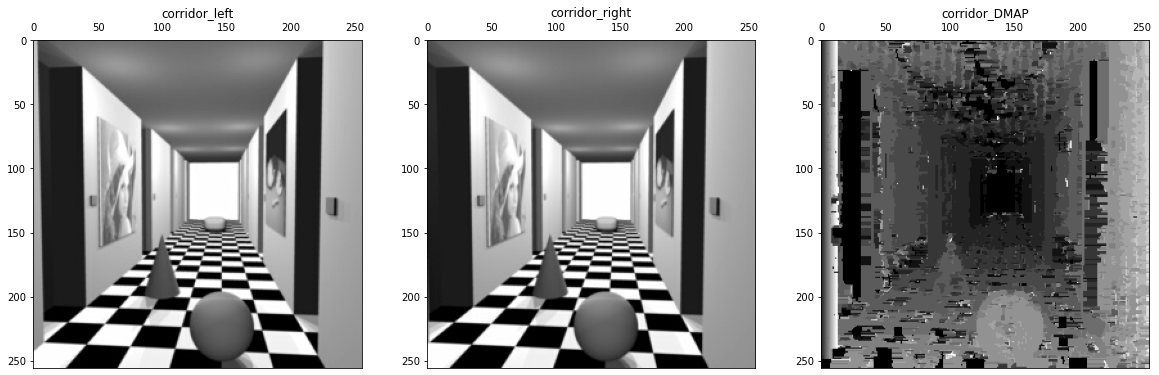

>>> Time taken: 6.274981 sec.


In [122]:
start = time.time()
guided_filter_disparity(stereo_images[0], D=15, algo='ssd',
                       agg_filter=3, guided_filter=0, lr_check=1, plot=True, save_dir=None)
end = time.time()
print('>>> Time taken: %f sec.' % (end - start))

..\out\GDMAP_corridor_D=15_ssd_af=3_gf=1.jpg


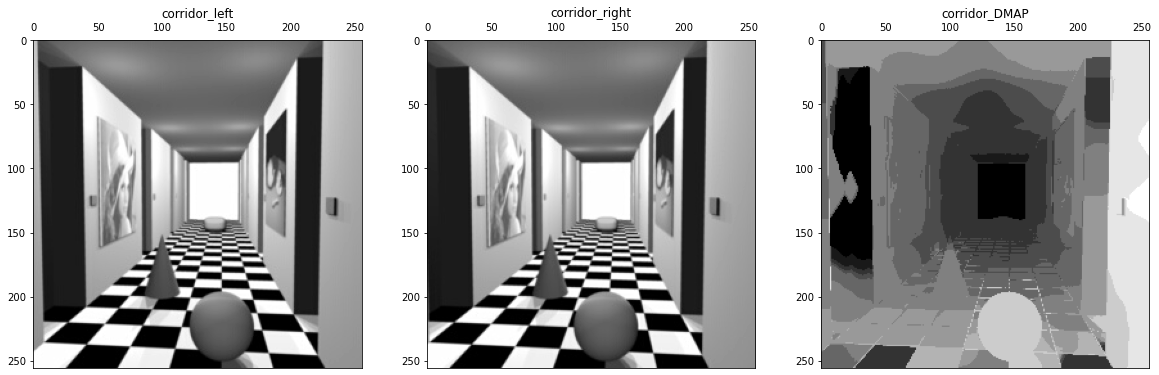

>>> Time taken: 7.480390 sec.


In [121]:
start = time.time()
guided_filter_disparity(stereo_images[0], D=15, algo='ssd',
                       agg_filter=3, guided_filter=1, lr_check=1, plot=True, save_dir=OUTPUT_DIR)
end = time.time()
print('>>> Time taken: %f sec.' % (end - start))

In [149]:
d_values = [20] #16, 20
agg_filters = [3] #, 3, 5, 9
gui_filters = [1] # 1
lrc_options = [1] # 1
algos = ['ssd'] #, 'sad'

img_d_maps = []

for s_i in stereo_images:
    d_maps = []
    for dv in d_values:
        for algo in algos:
            for af in agg_filters:
                for gf in gui_filters:
                    for lrc in lrc_options:
                        s_i =guided_filter_disparity(s_i, D=dv, algo=algo, agg_filter=af, 
                                                     guided_filter=gf, lr_check=lrc, 
                                                     plot=False, save_dir=None)

                        file_name = f"GD={dv}_{algo}_af={af}_gf={gf}_lrc={lrc}"
                        d_maps.append((file_name, s_i.DMAP))
    img_d_maps.append((s_i.name, d_maps))

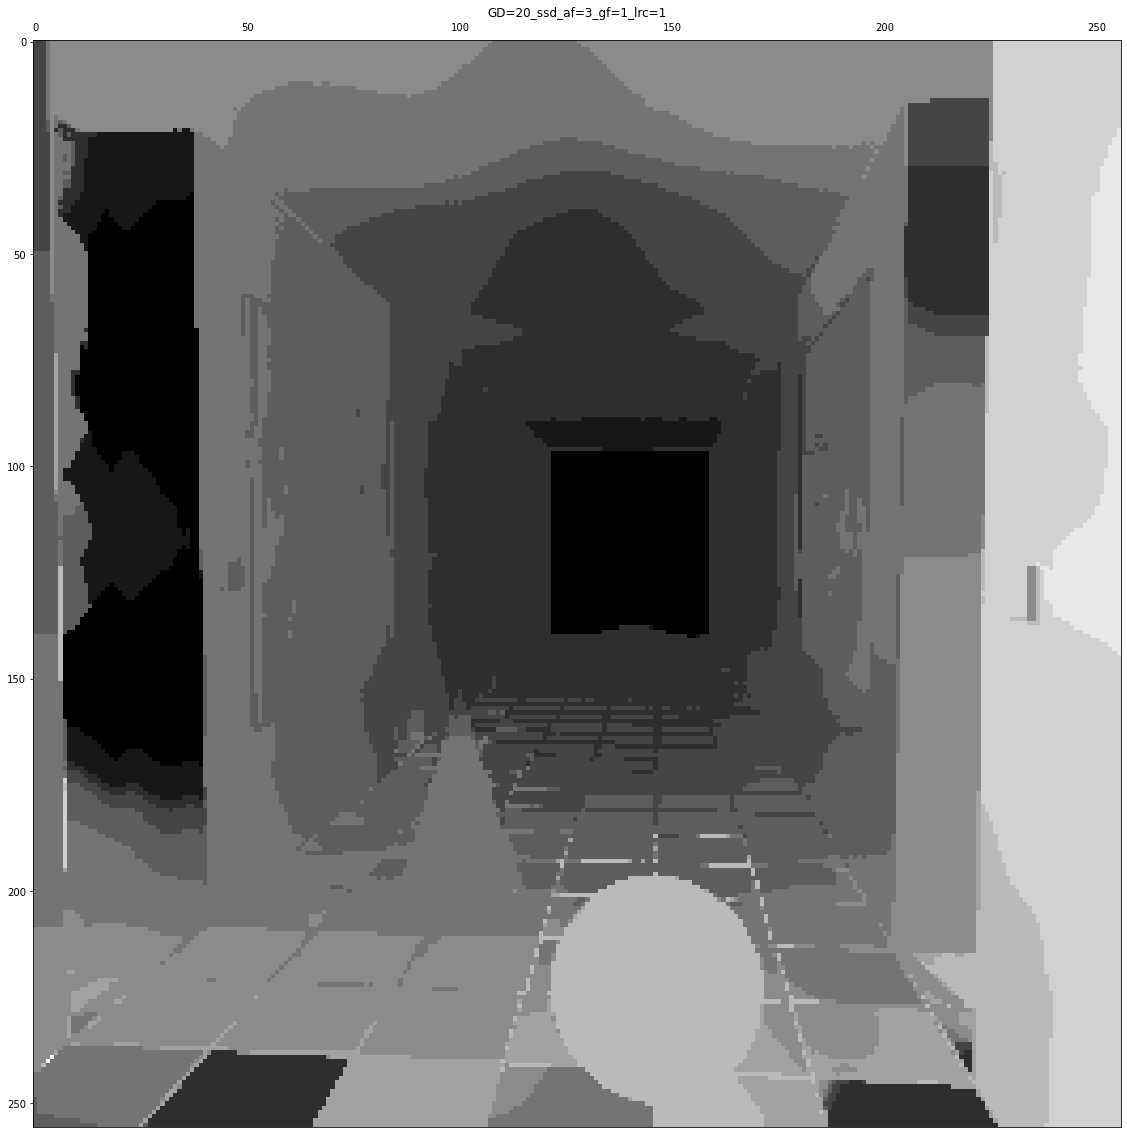

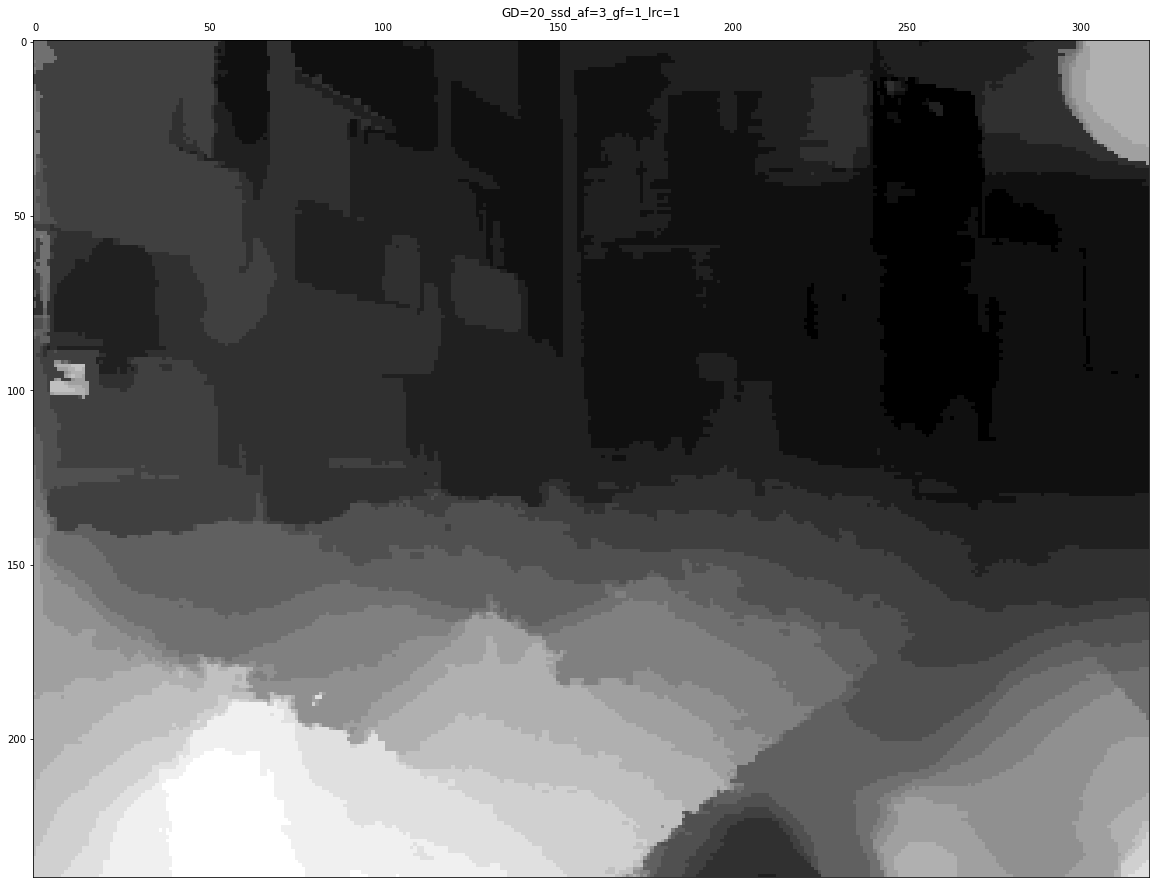

In [150]:
for img_name, img_maps in img_d_maps:
    plt.figure(1, figsize=(20, 20))
    for idx, d_maps in enumerate(img_maps):
        subplot_number = 100 + 10*len(img_maps) + idx+1
        plt.subplot(subplot_number)
        plt.title(d_maps[0])
        plt.tick_params(axis='both', which='major', labelsize=10, 
                        labelbottom = False, bottom=False, 
                        top = False, labeltop=True)
        plt.imshow(d_maps[1], cmap='gray')
#     save_path = os.path.join(OUTPUT_DIR, f"G_gf_VAR_{img_name}.jpg")
    save_path = os.path.join(OUTPUT_DIR, f"GDMAP_{d_maps[0]}_{img_name}.jpg")
    plt.savefig(save_path, dpi=160, bbox_inches='tight',pad_inches = 0)
    plt.show()

..\out\GDMAP_corridor_D=16_ssd_af=5_gf=1.jpg


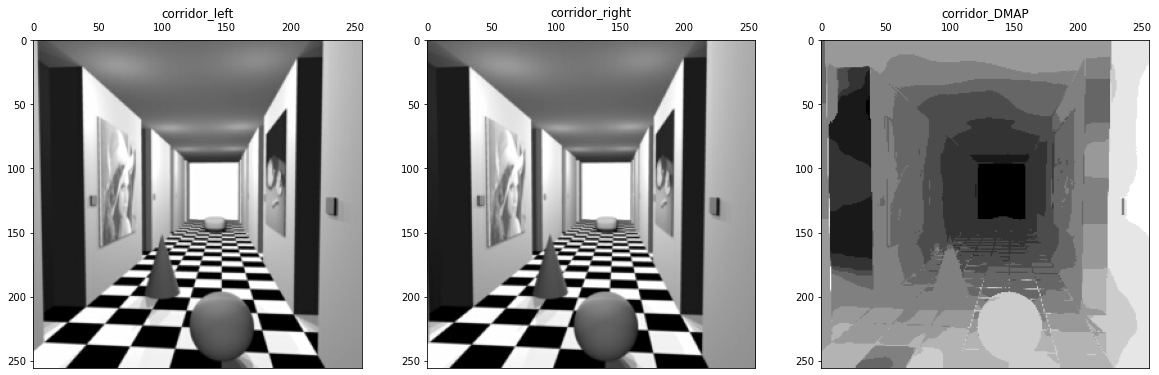

>>> Time taken: 8.232111 sec.


In [151]:
#final
start = time.time()
guided_filter_disparity(stereo_images[0], D=16, algo='ssd',
                       agg_filter=5, guided_filter=1, lr_check=1, plot=True, save_dir=OUTPUT_DIR)
end = time.time()
print('>>> Time taken: %f sec.' % (end - start))

..\out\GDMAP_triclopsi2_D=20_ssd_af=5_gf=1.jpg


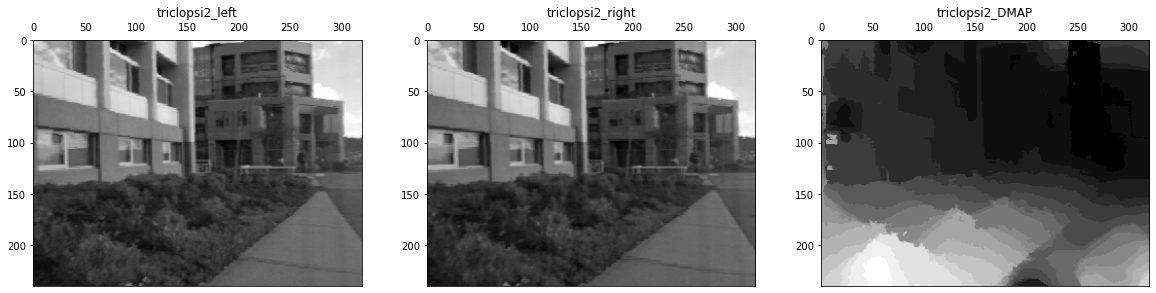

>>> Time taken: 10.896987 sec.


In [152]:
start = time.time()
guided_filter_disparity(stereo_images[1], D=20, algo='ssd',
                       agg_filter=5, guided_filter=1, lr_check=1, plot=True, save_dir=OUTPUT_DIR)
end = time.time()
print('>>> Time taken: %f sec.' % (end - start))

d_values = [8, 16, 20] #16, 20
agg_filters = [0, 3, 5, 9]
gui_filters = [0, 1]
algo = 'ssd'

for s_i in stereo_images:
    for dv in d_values:
        for af in agg_filters:
            for gf in gui_filters:
                if af > 0: 
                    cost = cost_aggregation_avg(cost, f=af)
                d_map = disparity_selection_wta(cost)    
                for rf in ref_filter:
                    if rf > 0: 
                        d_map = disparity_refinement_smooth(d_map, f=rf)
                    s_i.set_disparity_map(d_map)
                    save_path = os.path.join(OUTPUT_DIR, f"GDMAP_{s_i.name}_D={dv}_m={mv}_{algo}_af={af}_rf={rf}.jpg")
                    print(save_path)
                    show_disparity_map(s_i, save_path=save_path)